# COSE DA FARE

1. funzioni per training e print risultati
2. commentare modello, training, overfitting e risultati
3. grafico con differenza area tra curve
4. qualche altra info con altra configurazioni di hyperparams
5. pruning
6. analisi computazione micro con FPU
7. analisi prezzi
8. github

<br>

Organizzazione github:
- cartella con i files da caricare; Datasets
- cartella contenente i notebooks; Notebooks
- cartella contenente il progetto C; C Project
- fuori dalla cartella mettere PDF tesi;

# AUTOENCODER ECG PER ANOMALY DETECTION

***Our Dataset***

I segnali ECG acquisiti sono stati inizialmente filtrati (usando medie mobili e filtri hardware) e poi suddivisi in finestre utilizzando un altro notebook. Successivamente, le finestre ottenute sono state esportate in un file CSV. In questo file, ogni riga rappresenta una finestra del segnale, mentre ogni colonna corrisponde a un campione temporale all'interno della finestra (in totale 120 campioni per finestra, un valore scelto per bilanciare la risoluzione del segnale con i limiti computazionali e di memoria tipici dei microcontrollori, rispettando sempre il teorema del campionamento di Nyquist-Shannon).

Tuttavia, all'interno del pool di dati acquisiti non vi era certezza dell'assenza di anomalie, rendendo quindi necessario un processo di etichettatura. Sebbene il numero complessivo di segnali fosse sufficiente per un addestramento completo, non eravamo in grado di etichettarli accuratamente in autonomia.

Per ovviare a questo problema, è stato richiesto il supporto di un ex infermiere di cardiologia, al quale è stato affidato il compito di selezionare in modo casuale 100 segnali etichettati come normali, garantendo così una base di dati affidabile per la fase di Fine Tuning (vedere sezione Training Process).

Naturalmente, in uno scenario ideale si sarebbe dovuto etichettare l'intero dataset, ma ciò non è stato possibile per limiti di tempo e risorse.

<br>

***Online Dataset***

I dati etichettati a disposizione non erano sufficienti per un addestramento efficace del modello. Per questo motivo, si è reso necessario integrare un dataset online che utilizzasse la stessa derivazione ECG adottata per l'acquisizione (derivazione DI) e che contenesse segnali comparabili per morfologia ai nostri, oltre a essere privi di anomalie (etichettati quindi come **classe 0**).

È stato individuato il dataset X, composto da segnali normali provenienti da diverse persone. Tuttavia, i segnali di questo dataset erano stati acquisiti con una frequenza di campionamento pari a 500 Hz, superiore rispetto a quella dei nostri dati (120 campioni al secondo). Per rendere compatibili i dati, si è quindi proceduto con un'operazione di downsampling alla frequenza di campionamento utilizzata nel nostro sistema.

<br>

***Anomaly Dataset***

Un ulteriore passaggio fondamentale è stato l’individuazione di un dataset online contenente segnali anomali, che fossero quanto più possibile compatibili con i nostri tracciati ECG, sia in termini di derivazione (DI) sia di caratteristiche morfologiche. Tuttavia, non è stato trovato un dataset con segnali DI anomali già etichettati.

L’unico dataset che si avvicinava ai nostri requisiti era il dataset X, contenente tracciati ECG di diverse persone, all'interno dei quali erano presenti anche anomalie, seppur non etichettate in modo esplicito.

Come nel caso del nostro dataset acquisito, si è quindi richiesto il supporto di un ex infermiere specializzato in cardiologia per l’etichettatura manuale e l’individuazione delle onde anomale, al fine di isolare 100 segnali anomali (**classe 1**).

Anche in questo caso, l’etichettatura completa dell’intero dataset sarebbe stata auspicabile, ma è stata limitata a causa di vincoli di tempo e risorse disponibili.

<br>

***Autoencoder***

Il modello di intelligenza artificiale adottato è un **autoencoder**, scelto in alternativa a un **classificatore** tradizionale per diverse ragioni.
1. scarso numero di anomalie: il dataset contiene poche anomale etichettate (100), il che potrebbe introdurre un forte bias in fase di addestramento. È stato deciso di non utilizzare tecniche di data augmentation, per evitare di alterare la distribuzione naturale dei dati e per non rischiare fenomeni di overfitting dovuti alla ripetizione artificiale delle poche anomalie presenti (con o senza aggiunta di rumore). Questo rappresenta un limite significativo per un classificatore, che richiede tipicamente un bilanciamento tra le classi per funzionare correttamente;
2. capacità di generalizzazione dell’autoencoder: a differenza del classificatore, che può riconoscere solo le anomalie su cui è stato esplicitamente addestrato, l’autoencoder si basa sulla ricostruzione del segnale originale, dunque in grado di riconoscere anche anomalie non etichettate;
3. l’autoencoder rappresenta un modello ancora poco esplorato nel contesto dei microcontrollori, e per questo motivo si è scelto di valutarne pregi e limiti all’interno di un ambiente a risorse limitate.

<br>

***Training Process***

In una prima fase, il modello è stato addestrato utilizzando esclusivamente i 100 segnali acquisiti e etichettati come classe 0 (normali). Tuttavia, i risultati ottenuti non sono stati soddisfacenti. Anche includendo 100 segnali normali provenienti da un dataset online, mantenendo quindi un totale di 200 dati normali per evitare bias nell’autoencoder, il modello non ha mostrato miglioramenti significativi.

Per questo motivo, si è deciso di modificare l’approccio: il modello è stato inizialmente addestrato solo sui dati online etichettati come normali. Successivamente, è stata avviata una fase di Transfer Learning con Fine Tuning, utilizzando sia i 100 segnali acquisiti che 100 segnali dal dataset online, sempre appartenenti alla classe 0. In questa fase, i pesi dell’encoder sono stati freezati e il modello è stato raffinato agendo solamente sul decoder.

Grazie a questo approccio è stato possibile adattare il modello alla ricostruzione dei segnali acquisiti localmente, utilizzando soltanto 100 dati acquisiti normali.

<br>

***Hyperparameter Tuning***

L’autoencoder è in grado di segnalare la presenza di un’anomalia quando l’errore di ricostruzione supera una soglia prestabilita, definita ad esempio tramite analisi ROC. Questo approccio permette di generalizzare anche su anomalie mai viste in fase di addestramento, evitando la necessità di etichettare esplicitamente i segnali anomali nel training set.

Tuttavia, per garantire che il modello fosse non solo efficace ma anche compatibile con le limitazioni computazionali dei microcontrollori, è stato necessario un processo di tuning approfondito. Sono state valutate diverse configurazioni del modello, tenendo conto sia delle prestazioni in termini di rilevamento (es. AUC della curva ROC) sia del costo computazionale.

Alla fine, i parametri ottimali sono stati selezionati confrontando le curve AUC ottenute per ogni combinazione di iperparametri, in modo da bilanciare accuratezza e leggerezza del modello.



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, accuracy_score
import numpy as np
import random
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# il modello è stato poi testato con differenti seeds per la riproducibilità e randomicità
seed = 2025             # 42, 157, 2025
np.random.seed(seed)

# the fun applies MinMaxScaler, Shuffle, plots some examples with some prints info
# params are the dataset as pandas object and if the fun needs to split the dataset
def preprocessing(dataset, split=True, shuffle=True):
  dataset = (dataset - dataset.min(axis=1).values[:, None]) / (dataset.max(axis=1).values[:, None] - dataset.min(axis=1).values[:, None])
  x = dataset.values
  if shuffle:
    np.random.shuffle(x)

  # plot di alcune onde randomiche
  fig, axs = plt.subplots(2, 3, figsize=(15, 6))
  axs = axs.flatten()
  random_wave = random.sample(range(x.shape[0]), 6)
  for i in range(6):
      axs[i].plot(x[random_wave[i]])
      axs[i].set_title(f"Window {random_wave[i]+1}")
      axs[i].set_xlabel("Samples")
      axs[i].set_ylabel("Normalized Quantization Step")
      axs[i].grid(True)
  plt.tight_layout()
  plt.show()

  # plot unico con tutte le 6 onde sovrapposte
  plt.figure(figsize=(10, 4))
  for i in range(6):
      plt.plot(x[random_wave[i]], label=f"Window {random_wave[i]+1}")
  plt.xlabel("Samples")
  plt.ylabel("Normalized Quantization Step")
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

  print(f'Original Shape: {dataset.shape}')
  if split:
    # split train/validation 75% / 25%
    x_train, x_val = train_test_split(x, test_size=0.25, random_state=42)
    print(f"x_train shape: {x_train.shape}, x_val shape: {x_val.shape}")
    return x_train, x_val
  else:
    return x

def plot_loss(data, model):
  # calcolo della loss per ogni finestra
  total_loss = tf.reduce_mean(tf.abs(model(data) - data), axis=1)

  # max and min loss values and indeces
  max_index = tf.argmax(total_loss).numpy()
  max_value = total_loss[max_index].numpy()
  min_index = tf.argmin(total_loss).numpy()
  min_value = total_loss[min_index].numpy()
  print(f"Indice con errore massimo:  {max_index}")
  print(f"Valore dell'errore massimo: {max_value}")
  print(f"Indice con errore minimo:   {min_index}")
  print(f"Valore dell'errore minimo:  {min_value}")

  plt.figure(figsize=(10, 4))
  plt.plot(total_loss, marker='.', linestyle='-')
  plt.title("Losses")
  plt.xlabel("Window")
  plt.ylabel("MAE")
  plt.grid(True)
  plt.tight_layout()
  plt.show()

def plot_history(history):
  plt.figure(figsize=(8, 5))
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Train vs Validation Loss (con EarlyStopping)')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

## ONLINE DATASET

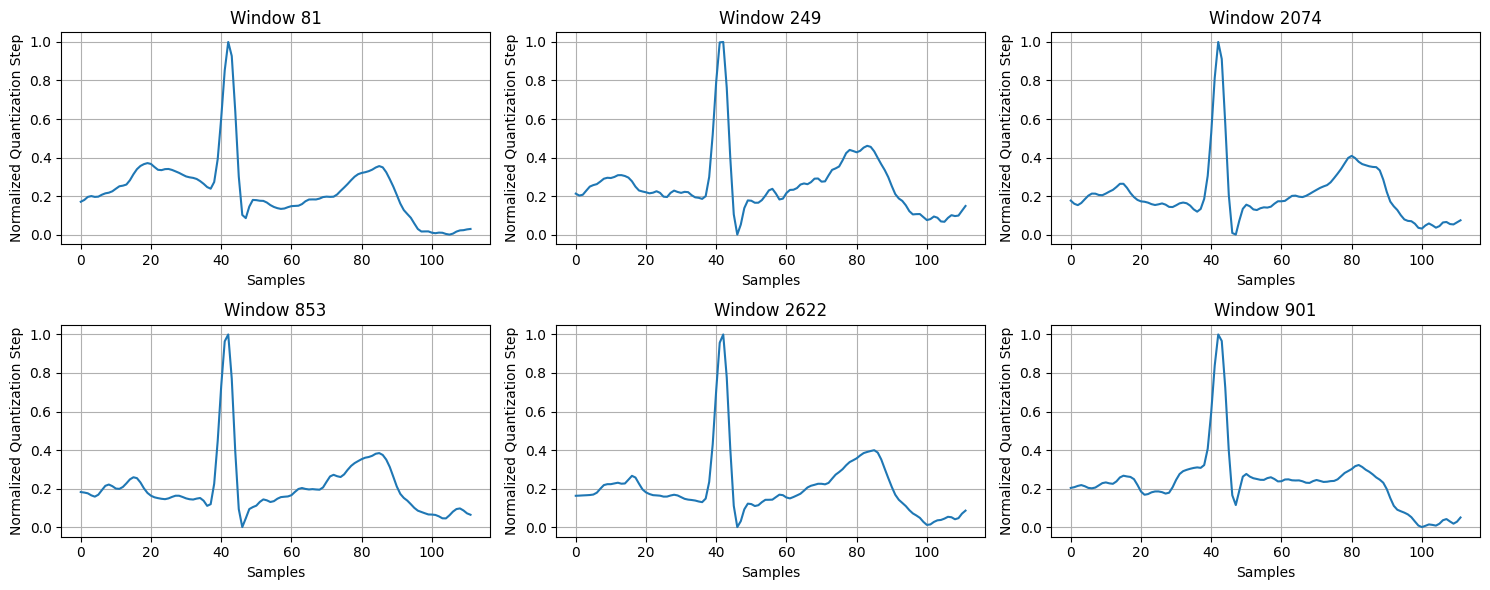

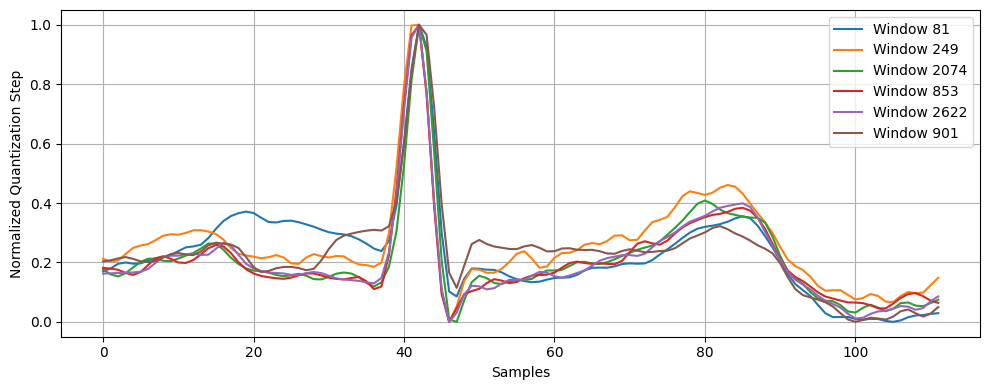

Original Shape: (3120, 112)
x_train shape: (2340, 112), x_val shape: (780, 112)


In [ ]:
df_train = pd.read_csv('finestre_120_train8.csv')
x_train, x_val = preprocessing(df_train)

## ANOMALY DATASET

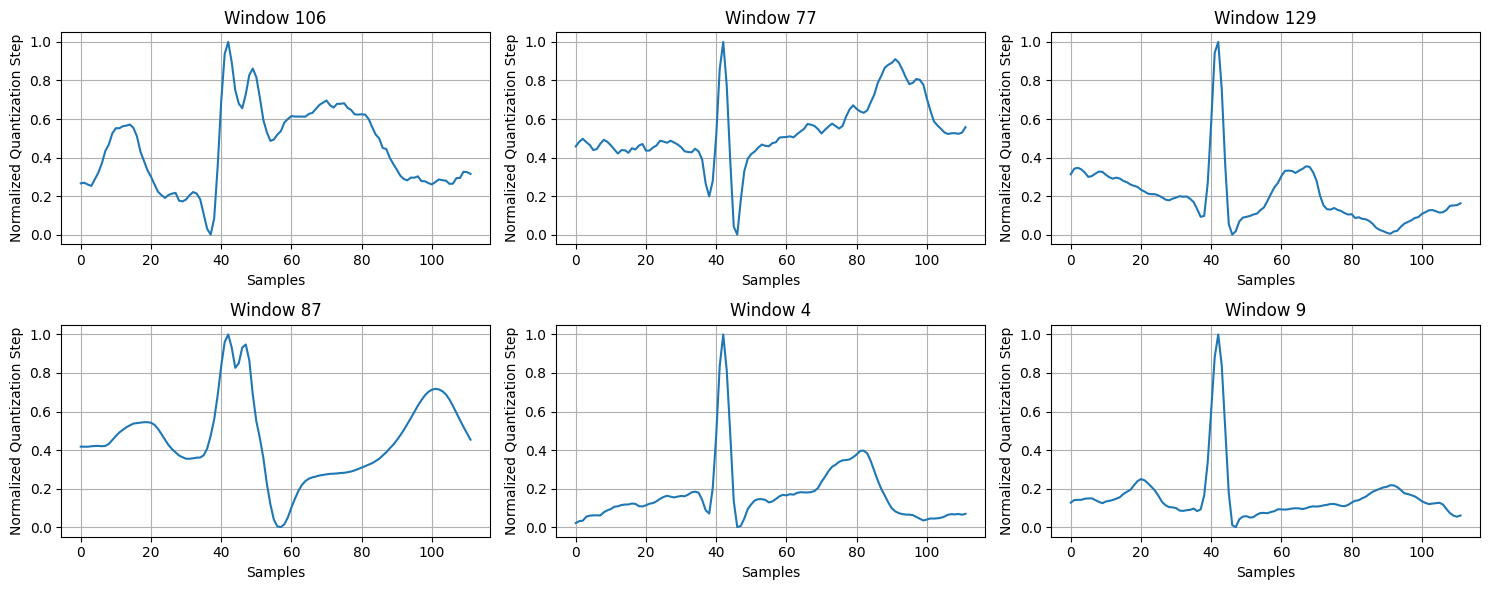

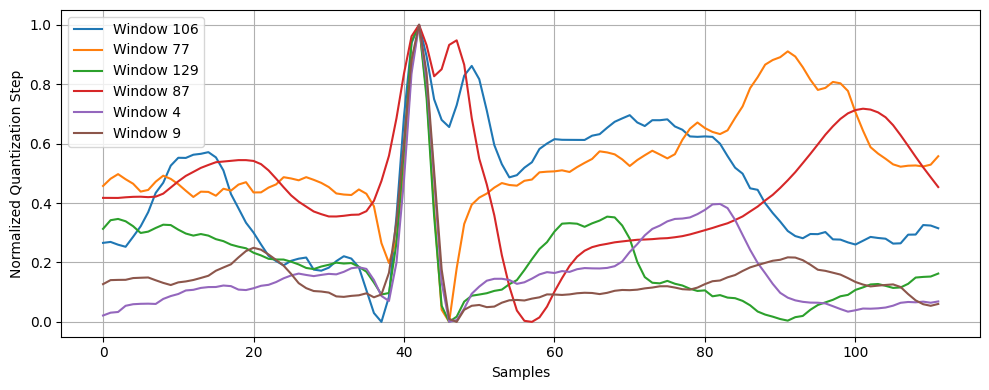

Original Shape: (132, 112)


In [ ]:
df_anomaly = pd.read_csv('anomaly100_2.csv')
x_anomaly = preprocessing(df_anomaly, split=False)

## COMBINED DATASET
This part includes the upload of 100 normal waves using the online dataset and 100 normal waves gets out from our dataset (labelled as normal).

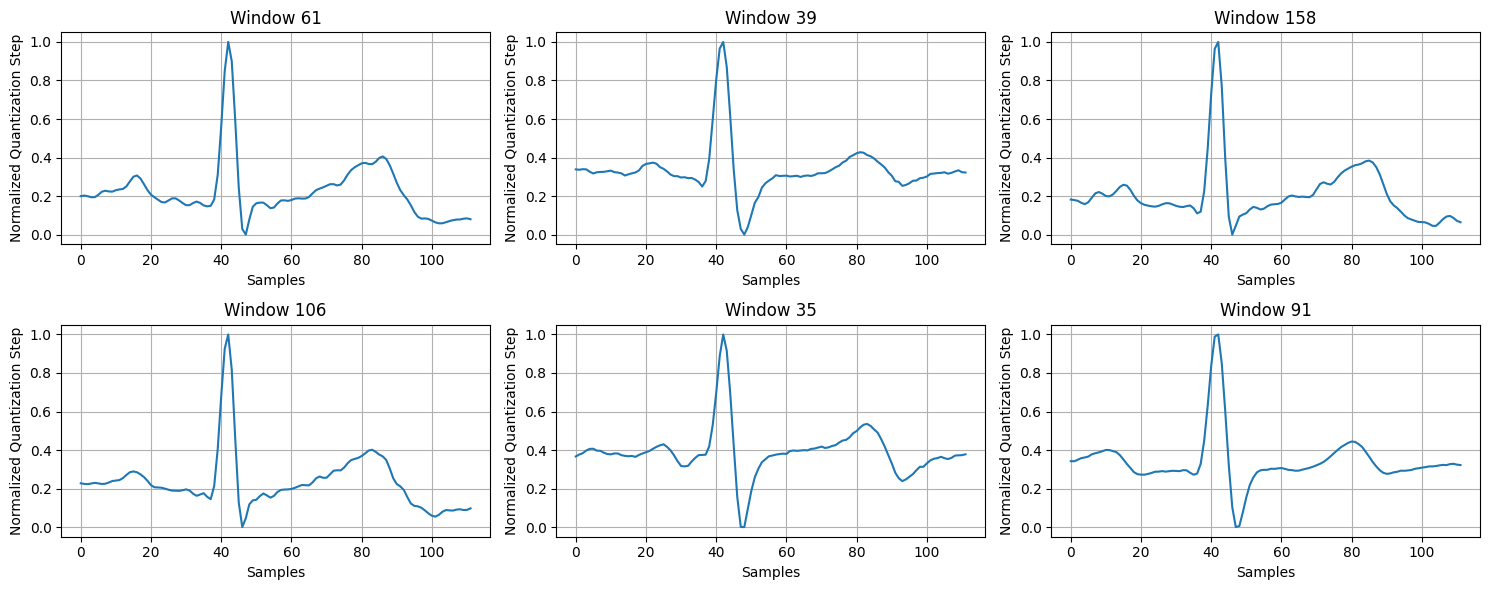

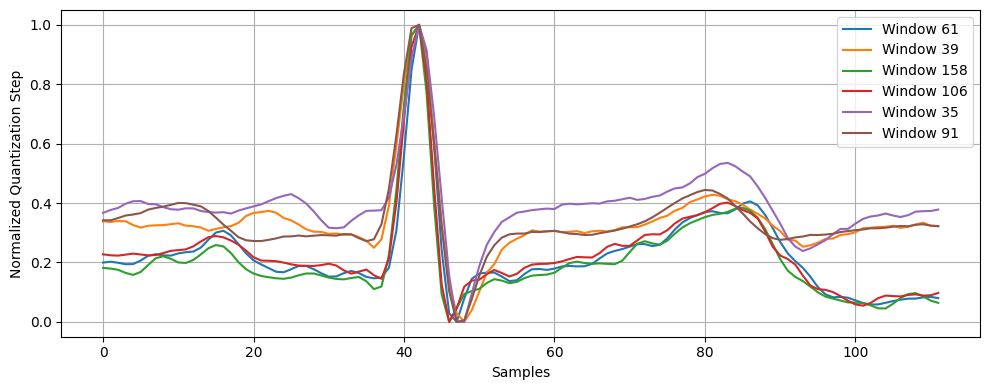

Original Shape: (200, 112)
x_train shape: (150, 112), x_val shape: (50, 112)


In [ ]:
df_combined = pd.read_csv('combined2.csv')#.iloc[:50]
x_combined_train, x_combined_val = preprocessing(df_combined)

## Test

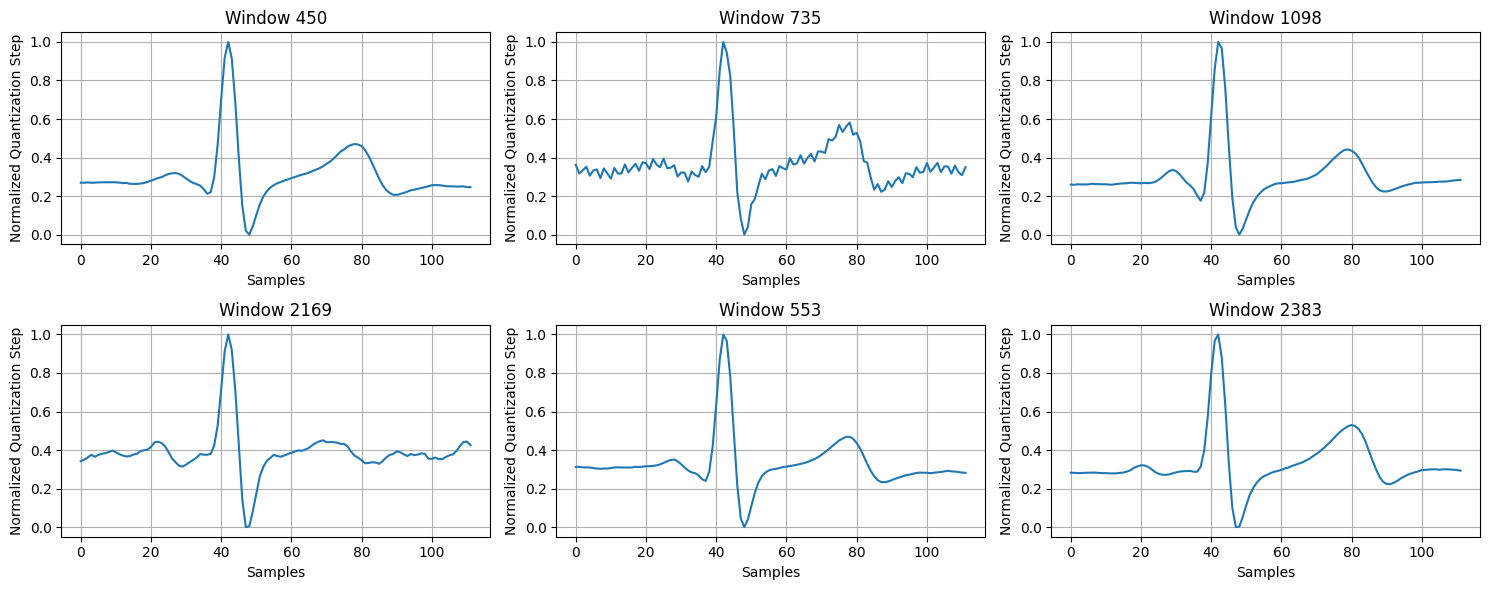

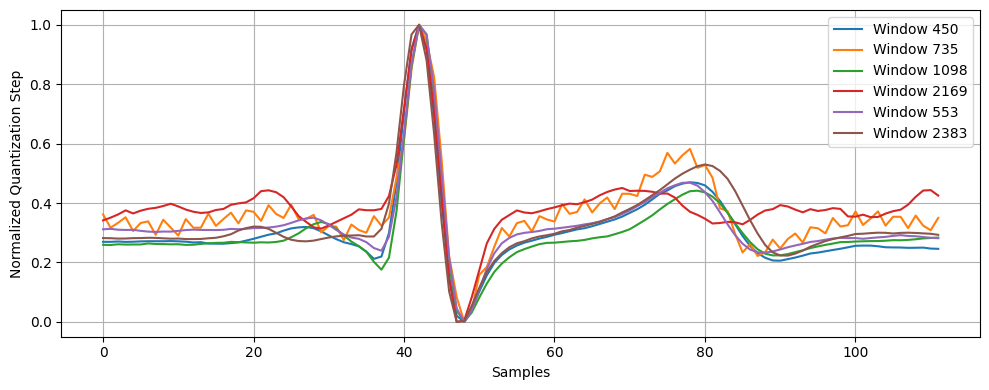

Original Shape: (2541, 112)


In [ ]:
df_test = pd.read_csv('ecg_test.csv')
x_test = preprocessing(df_test, split=False, shuffle=False)

## MODEL

Per l’addestramento dell’autoencoder sono stati testati diversi iperparametri, tra cui il valore del dropout, il numero di neuroni nei layer nascosti e la dimensione del batch.
Come funzioni di attivazione, è stata utilizzata ReLU negli hidden layers per il suo basso costo computazionale, scelta motivata dal vincolo che il modello deve essere eseguito su un microcontrollore.
Nell’output layer è stata invece adottata la hard sigmoid, una semplificazione della sigmoide tradizionale, anch’essa selezionata per garantire efficienza computazionale.

La loss utilizzata è stata MAE con Adam per l'aggiornamento dei pesi.


In [ ]:
# hyperparams
batch_size = 16
dropout = 0.3
epochs = 100
patience = 5
regularization = 0.000 # troppi pochi pesi, non va

class Autoencoder(Model):
    def __init__(self, size=100, dropout=0):
        super(Autoencoder, self).__init__(name="ECG_Autoencoder")
        self.size = size

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(2, activation='relu', kernel_regularizer=regularizers.l1(regularization))
        ], name="Encoder")

        # Decoder
        self.decoder = tf.keras.Sequential([
            layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dropout(dropout),
            layers.Dense(8, activation='relu', kernel_regularizer=regularizers.l1(regularization)),
            layers.Dense(self.size, activation='hard_sigmoid')
        ], name="Decoder")

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# test del modello con un dummy
autoencoder = Autoencoder(x_train.shape[1], dropout=dropout)
dummy_input = tf.zeros((1, x_train.shape[1]))
output = autoencoder(dummy_input)
print("Dimensione output dal modello:", output.shape)
autoencoder.compile(optimizer='adam', loss='mae')
n_weights = autoencoder.encoder.count_params() + autoencoder.decoder.count_params()
print(f"Numero totale di pesi addestrabili: {n_weights}, size in Byte: {n_weights*4}") # weights in fp32
print(f"Numero pesi Encoder: {autoencoder.encoder.count_params()}")
print(f"Numero pesi Decoder: {autoencoder.decoder.count_params()}")

Dimensione output dal modello: (1, 112)
Numero totale di pesi addestrabili: 2010, size in Byte: 8040
Numero pesi Encoder: 950
Numero pesi Decoder: 1060


## TRAIN

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2477 - val_loss: 0.0480
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0411 - val_loss: 0.0368
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.0347
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0340 - val_loss: 0.0327
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0318 - val_loss: 0.0310
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0294 - val_loss: 0.0288
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.0273
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0266 - val_loss: 0.0266
Epoch 9/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0263 - val_loss: 0.0262
Epoch 10/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0254 - val_loss: 0.0262
Epoch 11/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0263 - val_loss: 0.0259
Epoch 12/100
147/147 ━━━━━━━━━━━━━━━━━━━━

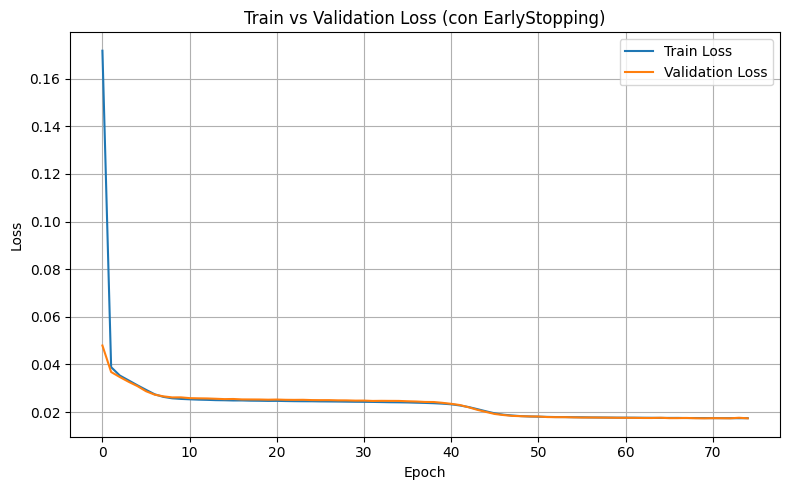

In [ ]:
# EarlyStopping callback (i.e stoppa il traning se la loss del validation set non migliora per 5 epoche)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
history = autoencoder.fit(
    x_train, x_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_val, x_val),
    callbacks=[early_stop]
)
plot_history(history)

Indice con errore massimo:  10
Valore dell'errore massimo: 0.054002828896045685
Indice con errore minimo:   6
Valore dell'errore minimo:  0.008337870240211487


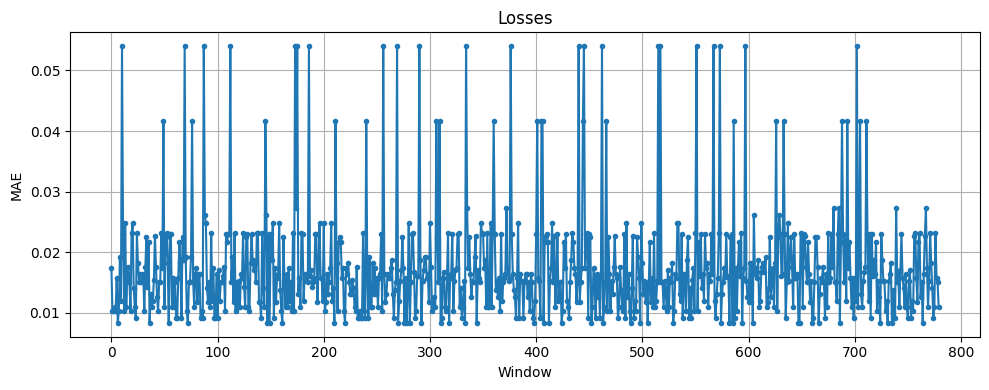

In [ ]:
plot_loss(x_val, autoencoder)

## Fine Tuning

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0407 - val_loss: 0.0330
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0398 - val_loss: 0.0326
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0395 - val_loss: 0.0325
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0370 - val_loss: 0.0321
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0350 - val_loss: 0.0319
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0365 - val_loss: 0.0317
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0363 - val_loss: 0.0317
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0346 - val_loss: 0.0317
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0358 - val_loss: 0.0313
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0332 - val_loss: 0.0312
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0360 - val_loss: 0.0310
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

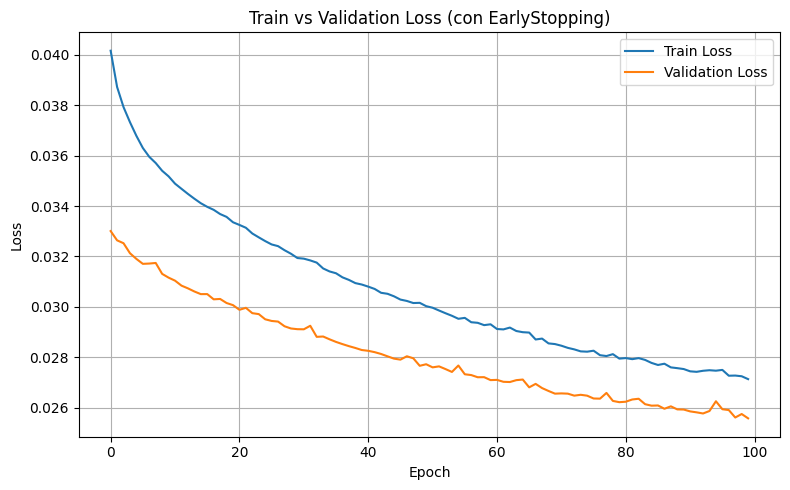

In [ ]:
# freeze di tutti i pesi dell'encoder
for layer in autoencoder.encoder.layers:
    layer.trainable = False

#autoencoder.decoder.layers[0].trainable=False
#autoencoder.decoder.layers[1].trainable=False

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
history = autoencoder.fit(
    x_combined_train, x_combined_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_combined_val, x_combined_val),
    callbacks=[early_stop]
)
plot_history(history)

Indice con errore massimo:  34
Valore dell'errore massimo: 0.048541244119405746
Indice con errore minimo:   22
Valore dell'errore minimo:  0.012184694409370422


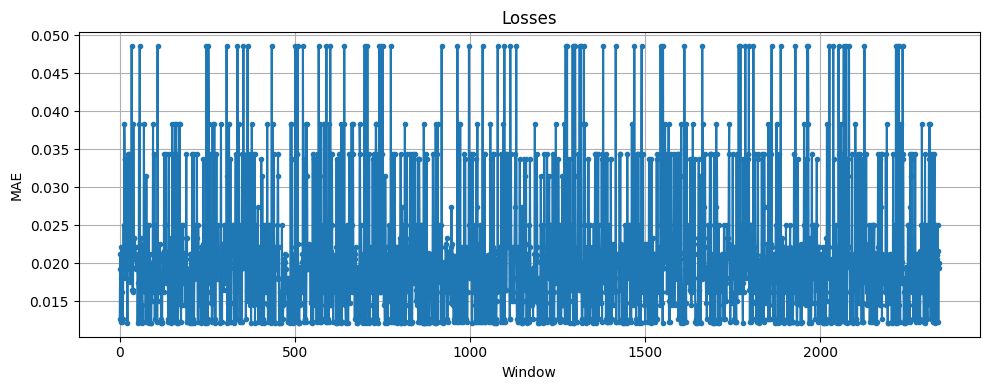

In [ ]:
plot_loss(x_train, autoencoder)

Indice con errore massimo:  0
Valore dell'errore massimo: 0.048541244119405746
Indice con errore minimo:   16
Valore dell'errore minimo:  0.012184694409370422


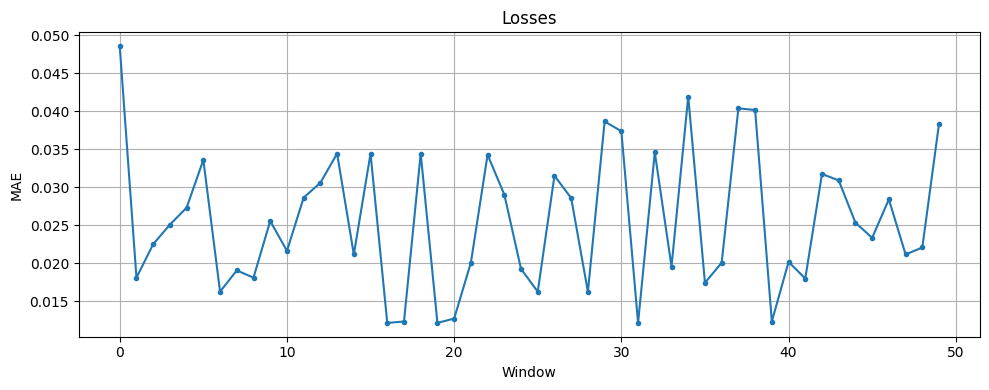

In [ ]:
plot_loss(x_combined_val, autoencoder)

Indice con errore massimo:  78
Valore dell'errore massimo: 0.36537081003189087
Indice con errore minimo:   88
Valore dell'errore minimo:  0.053368039429187775


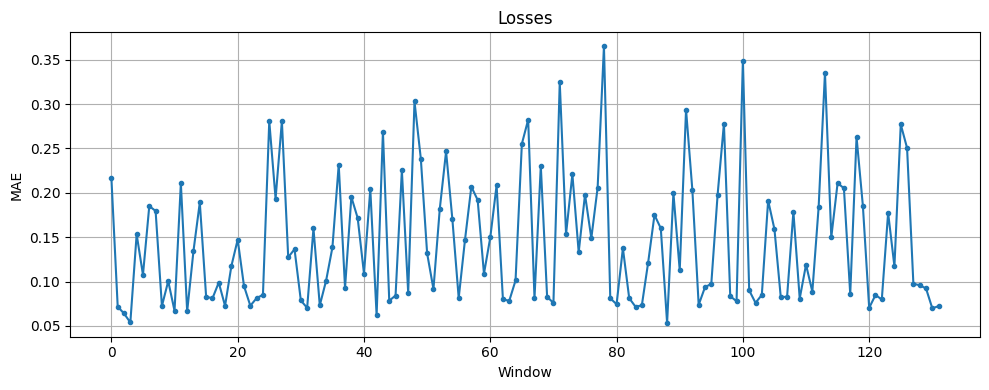

In [ ]:
plot_loss(x_anomaly, autoencoder)

Indice con errore massimo:  2619
Valore dell'errore massimo: 0.36537081003189087
Indice con errore minimo:   2015
Valore dell'errore minimo:  0.017372580245137215


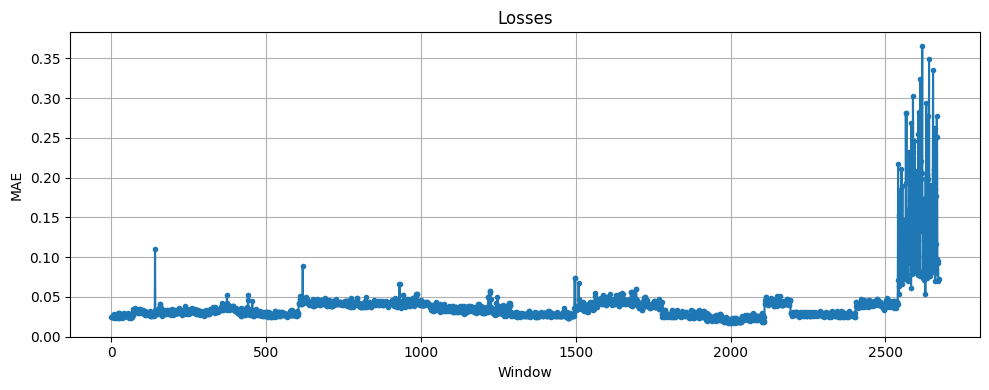

In [ ]:
plot_loss(np.concat([x_test,x_anomaly]), autoencoder)

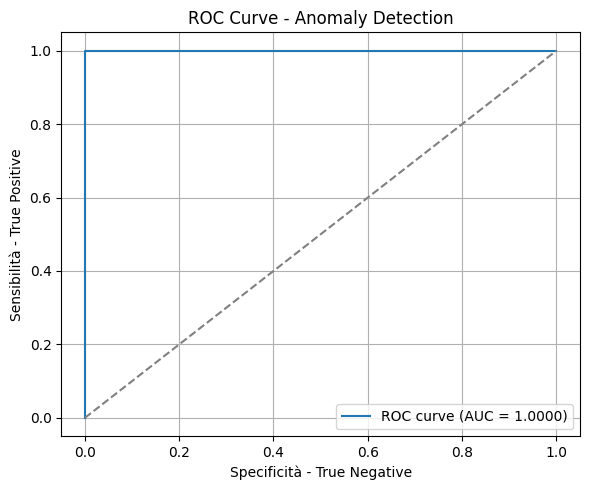

[       inf 0.3653708  0.28251168 0.2808575  0.19971919 0.19803596
 0.14885008 0.14730227 0.05336804 0.03459457 0.03443361 0.02164098
 0.02117706 0.02019479 0.0200909  0.01908064 0.01812662 0.01745459
 0.01628252 0.01274724 0.0123646  0.01218469]
Best threshold (closest to (0,1)): 0.053368


In [ ]:
combined_loss = tf.reduce_mean(tf.abs(autoencoder(x_combined_val) - x_combined_val), axis=1)
anomaly_loss = tf.reduce_mean(tf.abs(autoencoder(x_anomaly) - x_anomaly), axis=1)
total_loss = tf.concat([combined_loss, anomaly_loss], axis=0).numpy()
true_labels = np.concatenate([
    np.zeros(x_combined_val.shape[0], dtype=int),
    np.ones(x_anomaly.shape[0], dtype=int)
])

fpr, tpr, thresholds = roc_curve(true_labels, total_loss)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Specificità - True Negative")
plt.ylabel("Sensibilità - True Positive")
plt.title("ROC Curve - Anomaly Detection")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
print(thresholds)


# usare invece soglia con TP
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)
best_idx = np.argmin(distances)
best_threshold = thresholds[best_idx]
print(f"Best threshold (closest to (0,1)): {best_threshold:.6f}")

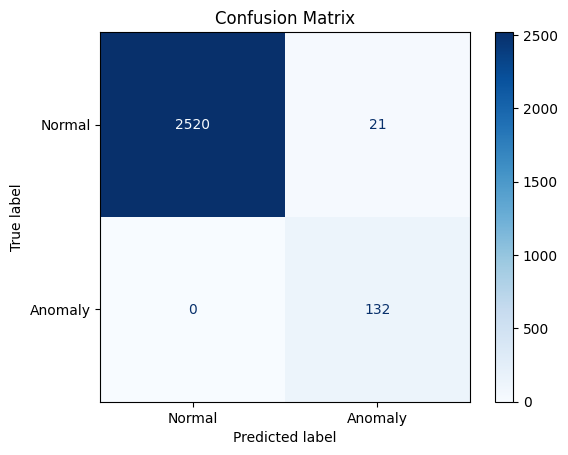

Accuracy: 0.9921


In [ ]:
test_loss = tf.reduce_mean(tf.abs(autoencoder(x_test) - x_test), axis=1)
total_loss = tf.concat([test_loss, anomaly_loss], axis=0).numpy()
true_labels = np.concatenate([
    np.zeros(x_test.shape[0], dtype=int),
    np.ones(x_anomaly.shape[0], dtype=int)
])


# confusion matrix + accuracy
predicted_labels = (total_loss >= best_threshold).astype(int)
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

Indici dei segnali classificati erroneamente: [ 141  618  930  931  985  986  987 1222 1223 1224 1496 1497 1509 1562
 1649 1651 1678 1679 1680 1694 1695]


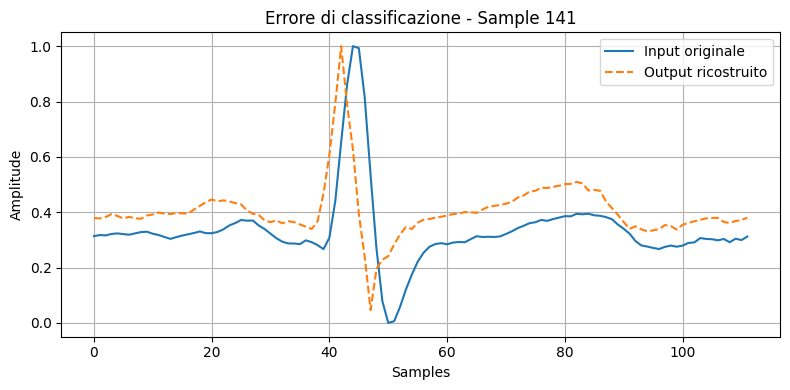

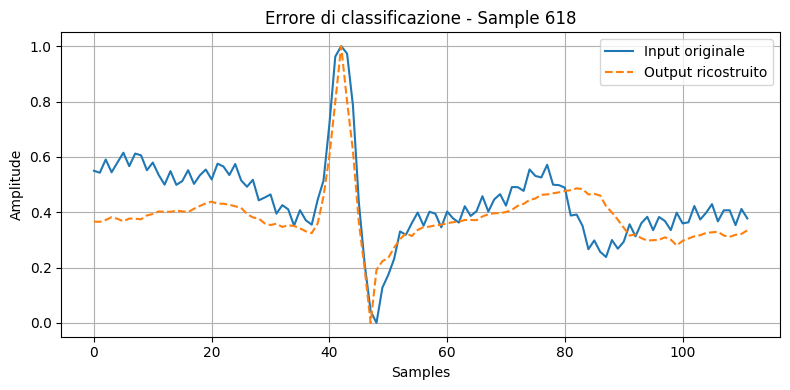

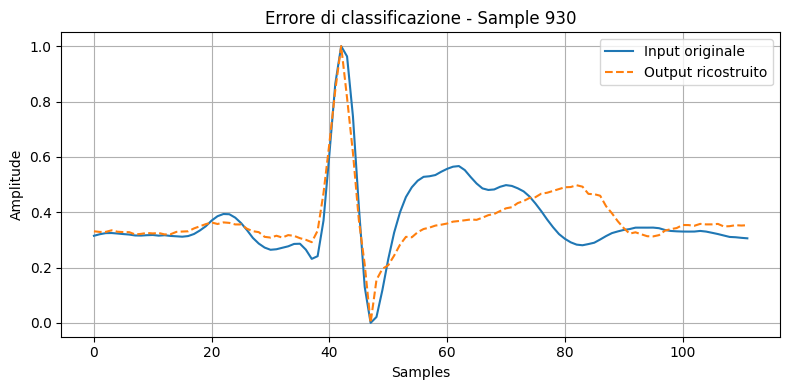

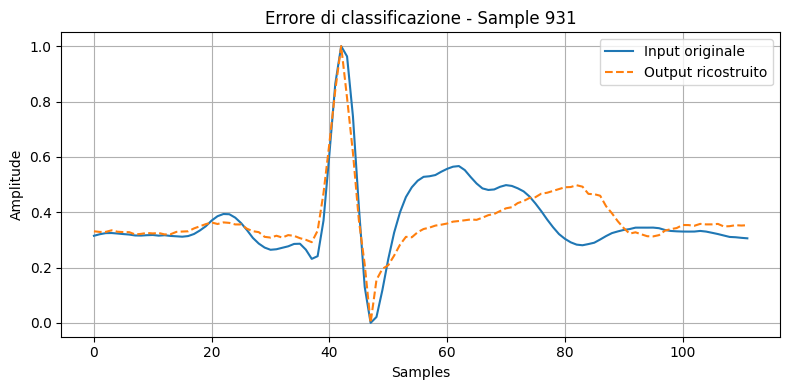

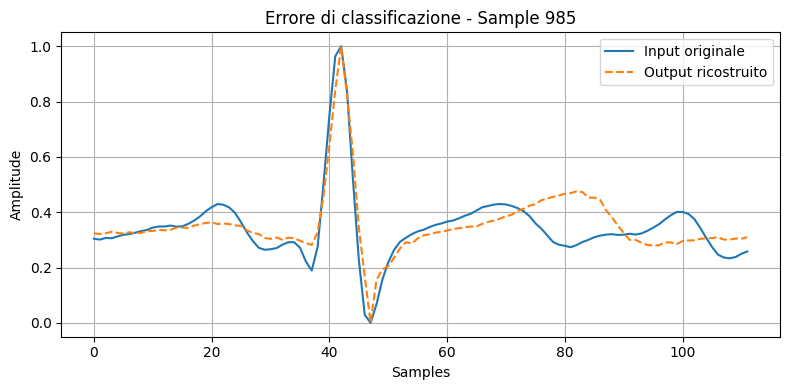

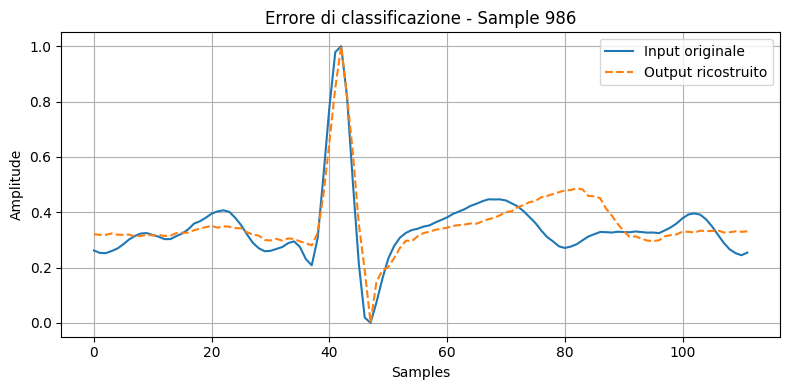

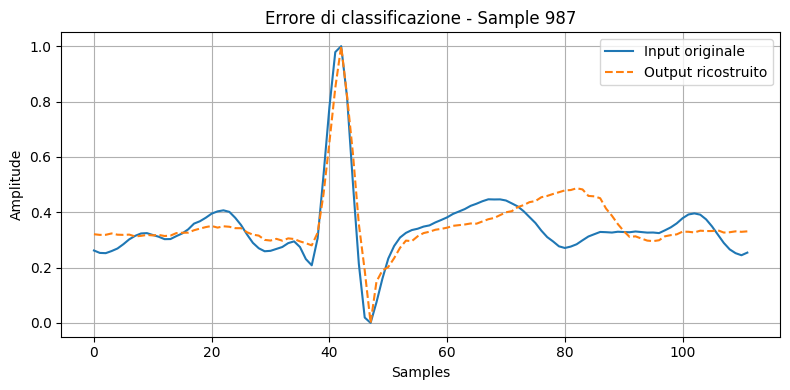

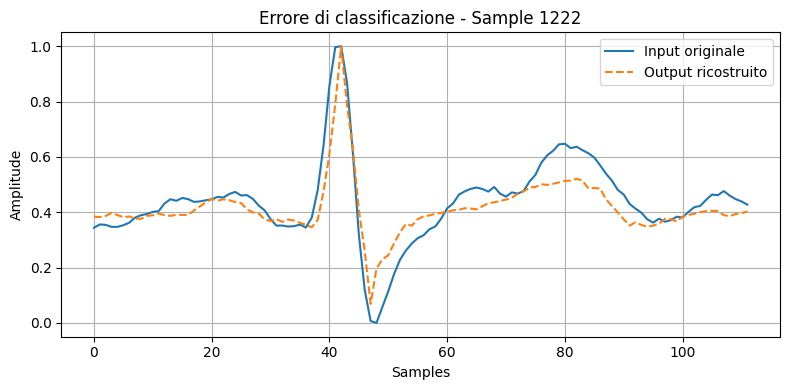

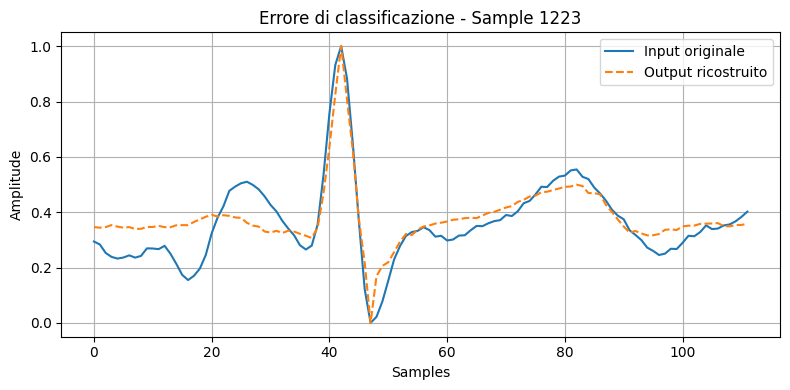

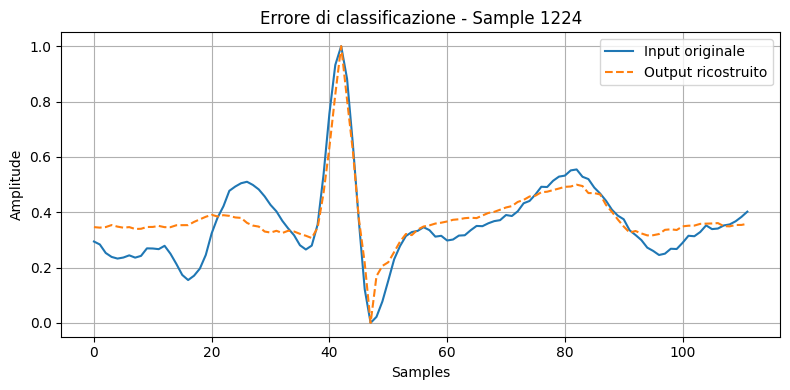

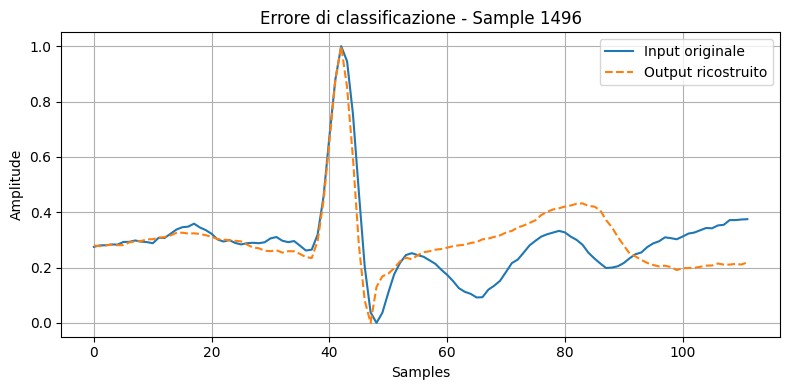

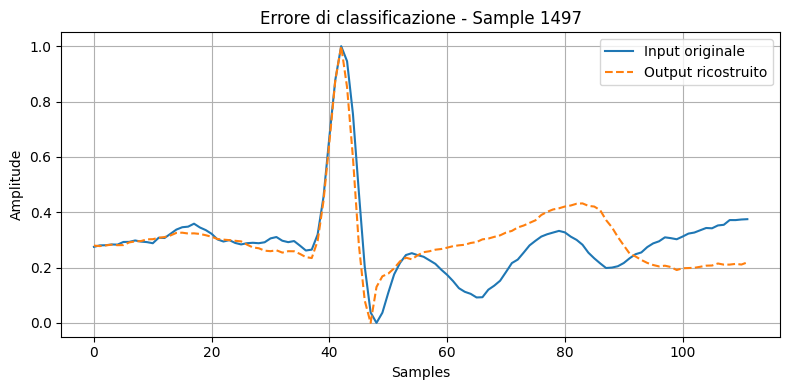

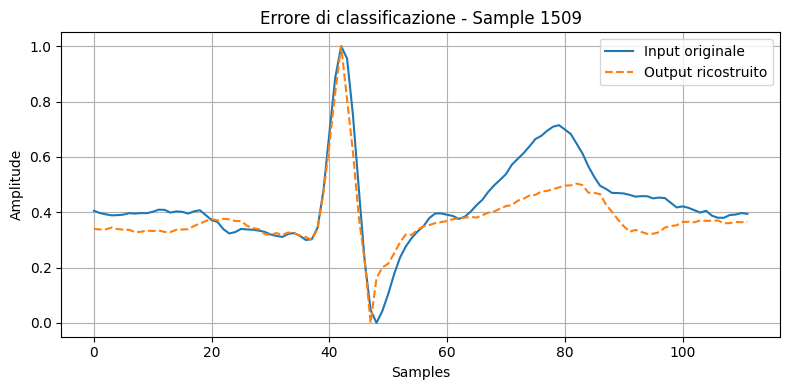

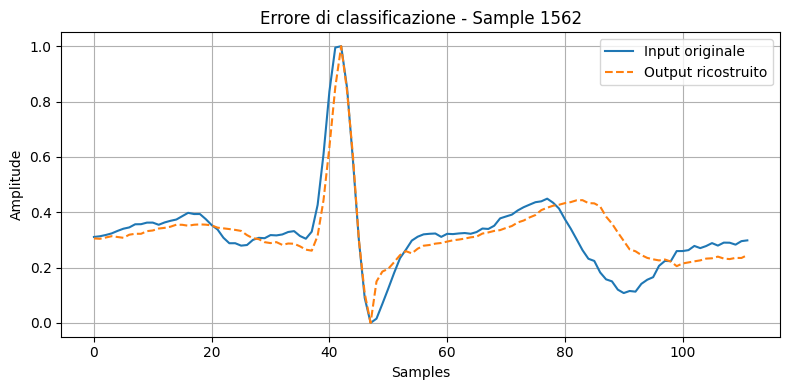

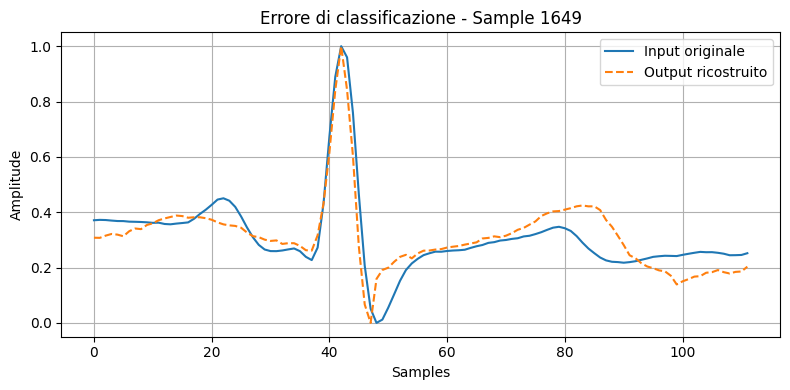

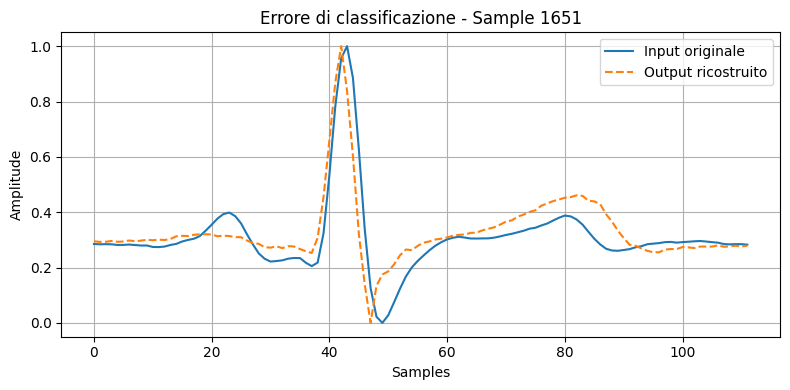

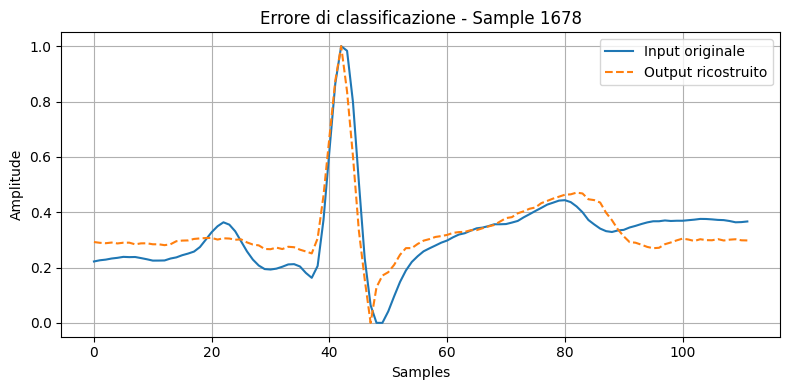

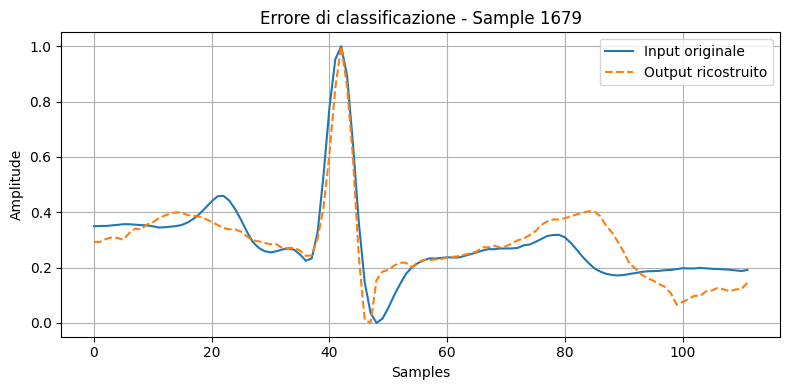

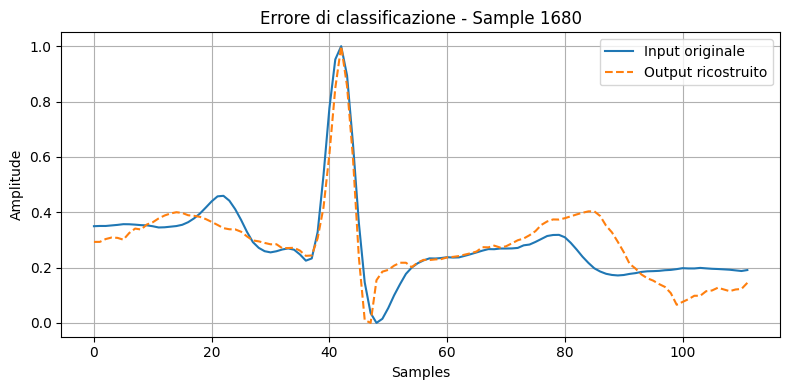

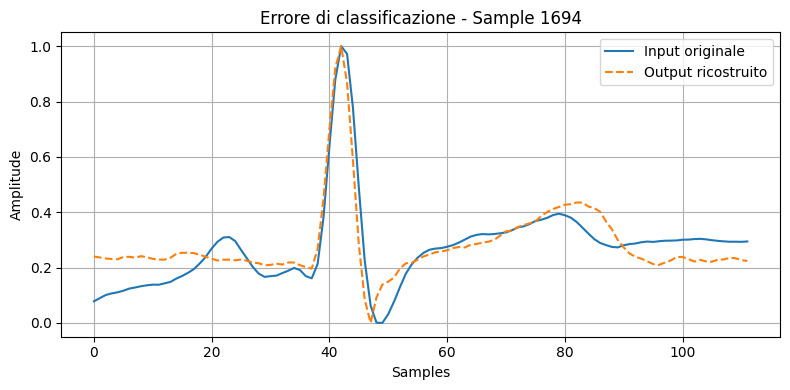

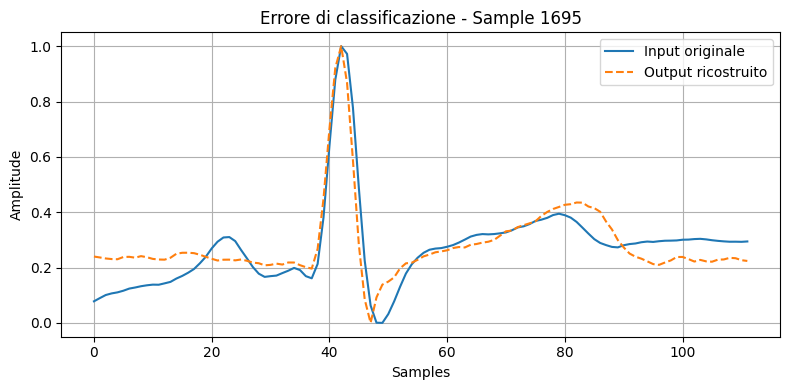

In [ ]:
wrong_indices = np.where(predicted_labels != true_labels)[0]
print("Indici dei segnali classificati erroneamente:", wrong_indices)

for i in wrong_indices:
    input_signal = x_test[i]
    output_signal = autoencoder(x_test[i:i+1]).numpy().squeeze()

    plt.figure(figsize=(8, 4))
    plt.plot(input_signal, label="Input originale")
    plt.plot(output_signal, label="Output ricostruito", linestyle="--")
    plt.title(f"Errore di classificazione - Sample {i}")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# SPAZZATURA

30° percentile dei pesi assoluti: 0.07806888
[ECG_Autoencoder] dense_30:
  → Pesi mantenuti : 551
  → Pesi tagliati  : 217
  → Totale pesi    : 768

[ECG_Autoencoder] dense_31:
  → Pesi mantenuti : 29
  → Pesi tagliati  : 3
  → Totale pesi    : 32

[ECG_Autoencoder] dense_32:
  → Pesi mantenuti : 7
  → Pesi tagliati  : 1
  → Totale pesi    : 8

[ECG_Autoencoder] dense_33:
  → Pesi mantenuti : 8
  → Pesi tagliati  : 0
  → Totale pesi    : 8

[ECG_Autoencoder] dense_34:
  → Pesi mantenuti : 28
  → Pesi tagliati  : 4
  → Totale pesi    : 32

[ECG_Autoencoder] dense_35:
  → Pesi mantenuti : 564
  → Pesi tagliati  : 204
  → Totale pesi    : 768

=== RIEPILOGO FINALE ===
Totale pesi       : 1616
Pesi mantenuti    : 1187
Pesi tagliati     : 429
Sparsità globale  : 26.55%


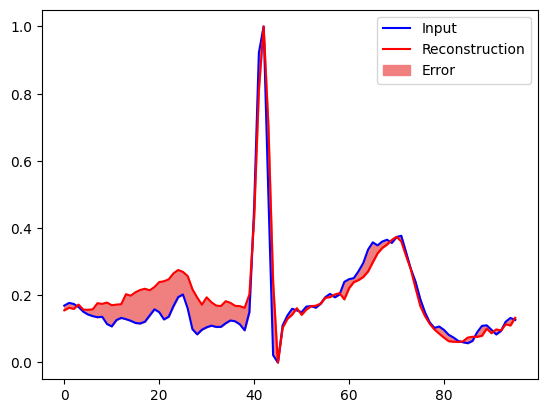

MAE post-pruning: 0.037085712
MAE pre-pruning: 0.027008492


In [ ]:
# Salva i pesi
autoencoder.save_weights('autoencoder.weights.h5')

# Ricrea il modello identico
autoencoder_copy = Autoencoder(x_combined_train.shape[1], dropout=dropout)
autoencoder_copy(tf.zeros((1, x_combined_train.shape[1])))

# Carica i pesi corretti
autoencoder_copy.load_weights('autoencoder.weights.h5')



def manual_prune_model(model, threshold=0.05):
    """
    Applica magnitude pruning a tutti i layer Dense in un modello Keras,
    scendendo ricorsivamente dentro Sequential/Model annidati.
    Stampa dettagli per layer e riepilogo totale.
    """
    total_weights = 0
    total_kept = 0

    def prune_layer(layer):
        nonlocal total_weights, total_kept

        if isinstance(layer, (tf.keras.Model, tf.keras.Sequential)):
            for sub_layer in layer.layers:
                prune_layer(sub_layer)

        elif isinstance(layer, tf.keras.layers.Dense):
            w, b = layer.get_weights()
            mask = np.abs(w) >= threshold
            w_pruned = w * mask
            layer.set_weights([w_pruned, b])

            kept = np.sum(mask)
            total = w.size
            pruned = total - kept

            total_weights += total
            total_kept += kept

            print(f"[{model.name}] {layer.name}:")
            print(f"  → Pesi mantenuti : {kept}")
            print(f"  → Pesi tagliati  : {pruned}")
            print(f"  → Totale pesi    : {total}\n")

    # Avvia pruning
    prune_layer(model)

    # Riepilogo finale
    pruned_total = total_weights - total_kept
    print("=== RIEPILOGO FINALE ===")
    print(f"Totale pesi       : {total_weights}")
    print(f"Pesi mantenuti    : {total_kept}")
    print(f"Pesi tagliati     : {pruned_total}")
    print(f"Sparsità globale  : {pruned_total / total_weights:.2%}")

def print_dense_weight_percentile(model, percentile=30):
    """Estrae tutti i pesi Dense e stampa il percentile specificato."""
    all_weights = []

    def collect_weights(m):
        for layer in m.layers:
            if isinstance(layer, (tf.keras.Model, tf.keras.Sequential)):
                collect_weights(layer)
            elif isinstance(layer, tf.keras.layers.Dense):
                w, _ = layer.get_weights()
                all_weights.append(np.abs(w).flatten())

    # Raccogli tutti i pesi
    collect_weights(model)

    # Unisci in un solo array
    if all_weights:
        flat_weights = np.concatenate(all_weights)
        flat_weights.sort()
        perc_val = np.percentile(flat_weights, percentile)
        print(f"{percentile}° percentile dei pesi assoluti: {perc_val:.8f}")
    else:
        print("Nessun layer Dense trovato.")

# Esempio di uso
print_dense_weight_percentile(autoencoder, percentile=30)

# Esempio di utilizzo:
# assume `autoencoder` è il tuo Model che contiene Encoder e Decoder
manual_prune_model(autoencoder_copy, threshold=0.06734277)

#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  #enc_img = autoencoder(data)
  dec_img = autoencoder_copy(data)
  #dec_img = tf.squeeze(dec_img, axis=-1)

  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

item = 88
plot(x_combined_train, item)

from tensorflow.keras.losses import MeanAbsoluteError
mae = MeanAbsoluteError()
print("MAE post-pruning:", mae(x_combined_train, autoencoder_copy(x_combined_train)).numpy())
print("MAE pre-pruning:", mae(x_combined_train, autoencoder(x_combined_train)).numpy())

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0374 - val_loss: 0.0365
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0364 - val_loss: 0.0359
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0363 - val_loss: 0.0354
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - val_loss: 0.0348
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0357 - val_loss: 0.0343
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0359 - val_loss: 0.0338
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0337 - val_loss: 0.0333
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0331 - val_loss: 0.0328
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0337 - val_loss: 0.0324
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0318 - val_loss: 0.0319
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0317 - val_loss: 0.0315
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

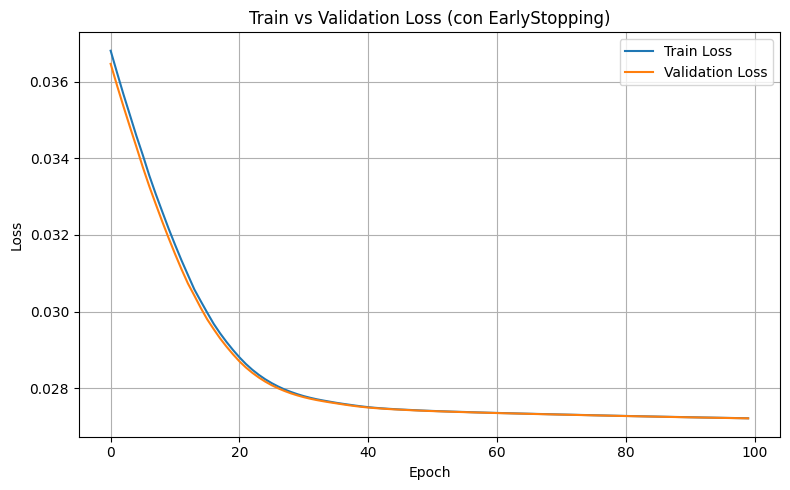

In [ ]:
from tensorflow.keras.optimizers import Adam
# EarlyStopping callback (i.e stoppa il traning se la loss del validation set non migliora per 5 epoche)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=patience,
    restore_best_weights=True
)
class FreezeZeroWeights(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        for layer in self.model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                w, b = layer.get_weights()
                mask = (w != 0).astype(np.float32)
                # Applica la maschera: ripristina a zero i pesi che erano nulli
                w = layer.kernel.numpy() * mask
                layer.kernel.assign(w)
freeze_callback = FreezeZeroWeights()
low_lr = 1e-5
optimizer = Adam(learning_rate=low_lr)
autoencoder_copy.compile(optimizer=optimizer, loss='mae')
history = autoencoder_copy.fit(
    x_combined_train, x_combined_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_combined_train, x_combined_train),
    callbacks=[early_stop, freeze_callback]
)
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss (con EarlyStopping)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

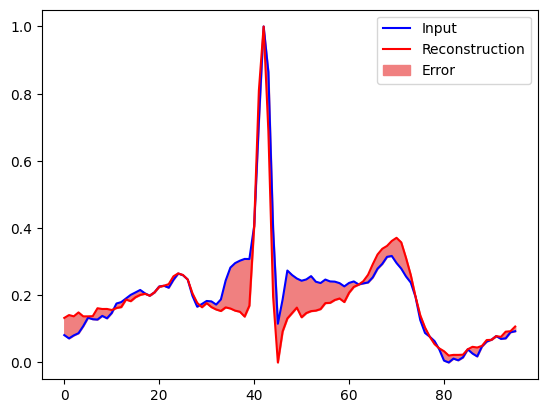

MAE post-pruning: 0.027209565
MAE pre-pruning: 0.027008492


In [ ]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  #enc_img = autoencoder(data)
  dec_img = autoencoder_copy(data)
  #dec_img = tf.squeeze(dec_img, axis=-1)

  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

item = 9
plot(x_combined_train, item)

from tensorflow.keras.losses import MeanAbsoluteError
mae = MeanAbsoluteError()
print("MAE post-pruning:", mae(x_combined_train, autoencoder_copy(x_combined_train)).numpy())
print("MAE pre-pruning:", mae(x_combined_train, autoencoder(x_combined_train)).numpy())

In [ ]:
# Estrai e concatena tutti i pesi e bias del layer
flattened = np.concatenate([arr.flatten() for arr in autoencoder_copy.layers[0].get_weights()])

# Ordina in base al valore assoluto
ordinato = flattened[np.argsort(np.abs(flattened))]

# Risultato
ordinato[:200]

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  

inserire spiegazione per val train loss

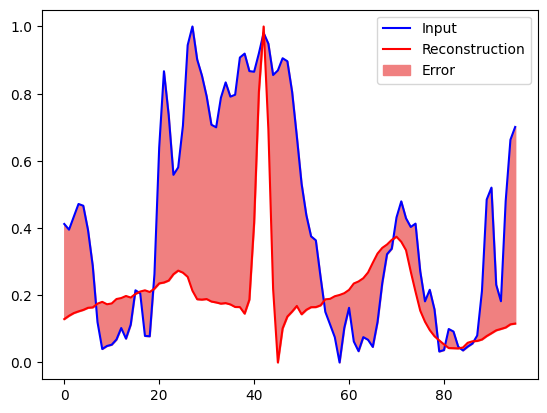

In [ ]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  #enc_img = autoencoder(data)
  dec_img = autoencoder(data)
  #dec_img = tf.squeeze(dec_img, axis=-1)

  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

item = 50
plot(x_anomaly, item)

In [ ]:
#Now let's define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  #enc_img = autoencoder(data)
  dec_img = autoencoder(data)
  #dec_img = tf.squeeze(dec_img, axis=-1)

  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(data.shape[1]), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

for item in range(1000,1100):
  plot(x_anomaly, item)

IndexError: index 1000 is out of bounds for axis 0 with size 100

## Future Steps

Concludendo, il modello ha ottenuto ottimi risultati anche in presenza di un basso costo computazionale e con un numero limitato di dati etichettati. Questo dimostra che l’autoencoder può rappresentare una valida alternativa ai classificatori tradizionali, soprattutto in contesti dove l’etichettatura è onerosa o poco praticabile.

Naturalmente, per validare ulteriormente l’efficacia del modello, futuri sviluppi dovranno includere:
- analisi con diverse anomalie con diverse derivazioni ECG;
- integrazione di tecniche di quantizzazione per l’ottimizzazione su microcontrollori;
- utilizzo di CNN 1D, per migliorare la capacità del modello di catturare pattern temporali complessi.

Altri modelli promettenti da esplorare includono il VAE (Variational Autoencoder) e il CI-VAE (Class-Informed VAE), che integra un classificatore nello spazio latente. Tuttavia, questi approcci sono stati momentaneamente scartati a causa delle risorse limitate e del tempo a disposizione per la tesi, oltre al maggior costo computazionale richiesto.

Infine, un’interessante prospettiva futura consiste nell’implementazione di un Fine Tuning locale del modello direttamente sul microcontrollore, per adattarlo all’utente specifico con un impatto minimo sulle risorse.